In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

<h2>1. Loading & Preprocessing the Data</h2>

<h4> - Load the dataset from the iris.csv file into a Pandas DataFrame.</h4>

In [69]:
df = pd.read_csv('Iris.csv')

In [70]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


<h4> - Encode the target column (species) as integer labels (0, 1, 2).</h4>

In [71]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [72]:
label = LabelEncoder()
df['Species'] = label.fit_transform(df['Species'])

In [73]:
df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [74]:
df['Species'].unique()

array([0, 1, 2])

<h4> - Split the dataset into 80% training and 20% testing.</h4>

In [75]:
X = df.drop('Species', axis=1)
y = df['Species']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<h4> - Normalize the feature values using StandardScaler).</h4>

In [77]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h4> - Converting Training and Testing Data to PyTorch Tensors:</h4>

In [78]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values)

<h2>2. Visualising the Data</h2>

<h4> - Create box plots for each feature (sepal length, sepal width, petal length, petal
width), separated by species to show the distribution and spread per class.</h4>

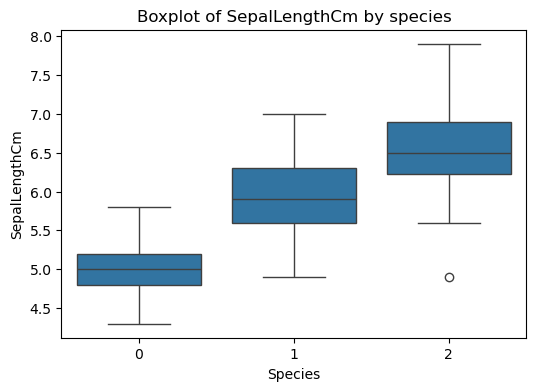

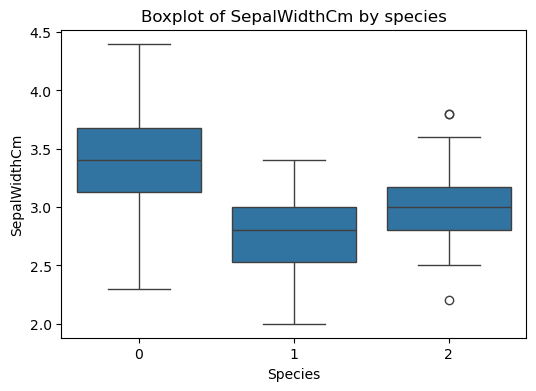

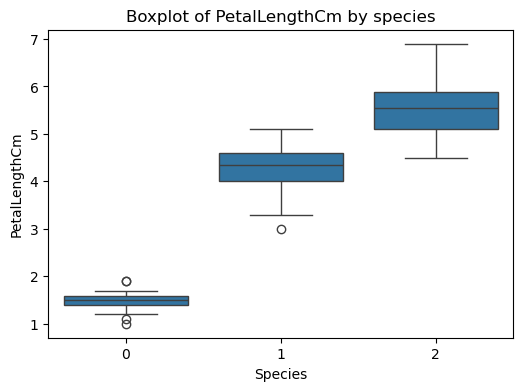

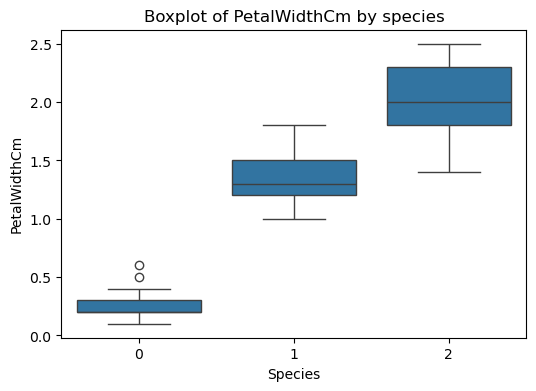

In [79]:
for col in df.columns[1:5]:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Species', y=col, data=df)
    plt.title(f'Boxplot of {col} by species')
    plt.show()

<h4> - Create a pairplot (scatterplot matrix) of all features, colored by
species.</h4>

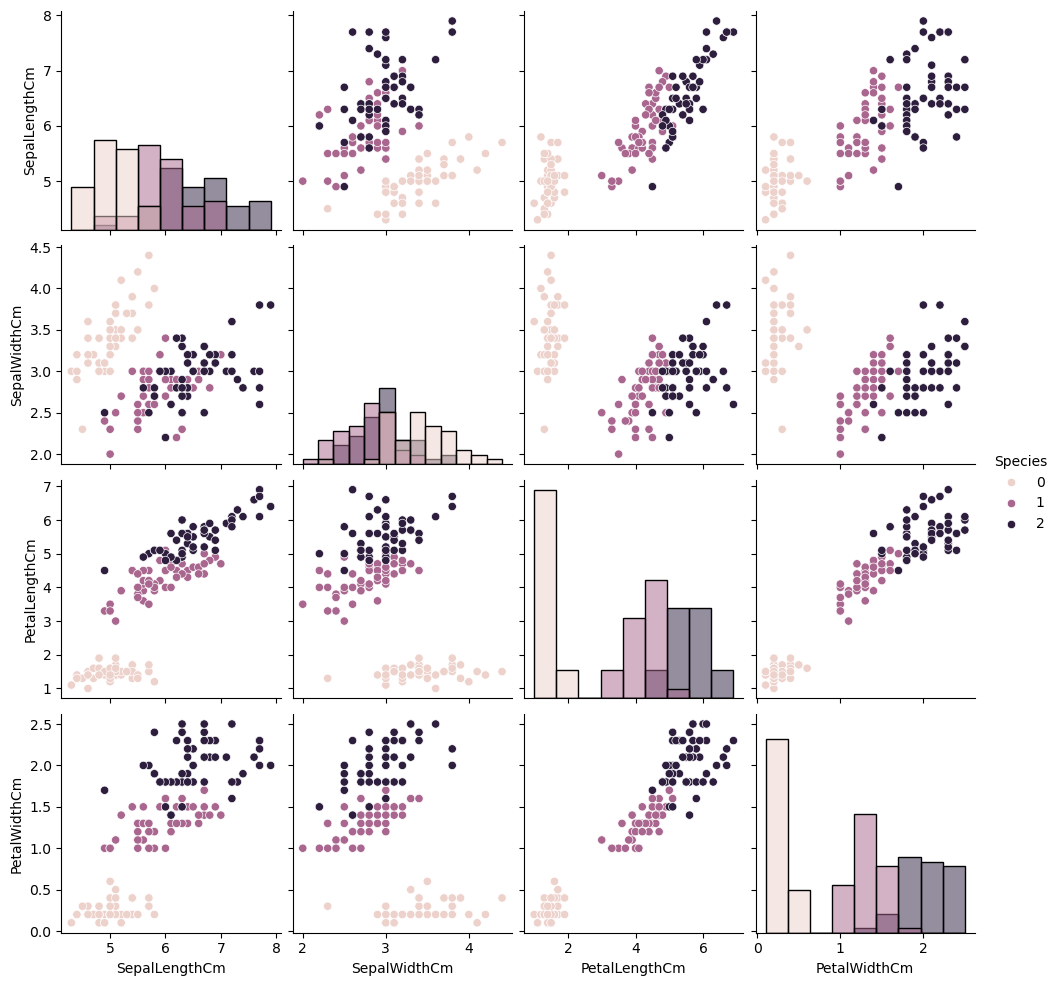

In [80]:
sns.pairplot(df, hue='Species', diag_kind='hist', vars = df.columns[1:5])
plt.show()

<h2>3. Building the Neural Network</h2>

<h4> - Building the Network Architecture :<br>  1. 4 Neurons in Input Layer<br>  2. 16 Neurons with ReLU activation in the Hidden Layer<br>  3. 3 Neurons in Output Layer</h4>

In [58]:
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

<h4> - Using CrossEntropyLoss as the loss function<br> - Using an optimizer, Adam
</h4>

In [38]:
model = IrisNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

<h2>4. Training the Model</h2>

In [81]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

input_size = X_train_tensor.shape[1] 
hidden_size = 32 
output_size = len(torch.unique(y_train_tensor))

model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, output_size)
)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Evaluate every 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            # Training accuracy and loss
            train_pred = torch.argmax(model(X_train_tensor), dim=1)
            train_acc = accuracy_score(y_train_tensor.cpu().numpy(), train_pred.cpu().numpy())  # Convert to numpy if needed
            train_loss = criterion(model(X_train_tensor), y_train_tensor).item()

            # Testing accuracy and loss
            test_pred = torch.argmax(model(X_test_tensor), dim=1)
            test_acc = accuracy_score(y_test_tensor.cpu().numpy(), test_pred.cpu().numpy())  # Convert to numpy if needed
            test_loss = criterion(model(X_test_tensor), y_test_tensor).item()

            print(f"Epoch {epoch}:")
            print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
            print(f"Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}\n")

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

Epoch 1:
Train Loss: 1.0511, Test Loss: 1.0492
Train Acc: 0.3500, Test Acc: 0.3667

Epoch 10:
Train Loss: 0.9516, Test Loss: 0.9565
Train Acc: 0.5333, Test Acc: 0.5667

Epoch 20:
Train Loss: 0.8567, Test Loss: 0.8678
Train Acc: 0.6250, Test Acc: 0.6667

Epoch 30:
Train Loss: 0.7758, Test Loss: 0.7917
Train Acc: 0.6583, Test Acc: 0.7000

Epoch 40:
Train Loss: 0.7058, Test Loss: 0.7255
Train Acc: 0.7583, Test Acc: 0.7333

Epoch 50:
Train Loss: 0.6443, Test Loss: 0.6674
Train Acc: 0.8333, Test Acc: 0.7667

Epoch 60:
Train Loss: 0.5900, Test Loss: 0.6159
Train Acc: 0.8500, Test Acc: 0.8000

Epoch 70:
Train Loss: 0.5417, Test Loss: 0.5699
Train Acc: 0.8667, Test Acc: 0.8333

Epoch 80:
Train Loss: 0.4988, Test Loss: 0.5288
Train Acc: 0.8833, Test Acc: 0.8333

Epoch 90:
Train Loss: 0.4605, Test Loss: 0.4916
Train Acc: 0.8917, Test Acc: 0.8333

Epoch 100:
Train Loss: 0.4260, Test Loss: 0.4579
Train Acc: 0.9000, Test Acc: 0.8333



<h2>5. creating plots</h2>

<h4> - Plot 1: Training and test loss vs. epochs</h4>

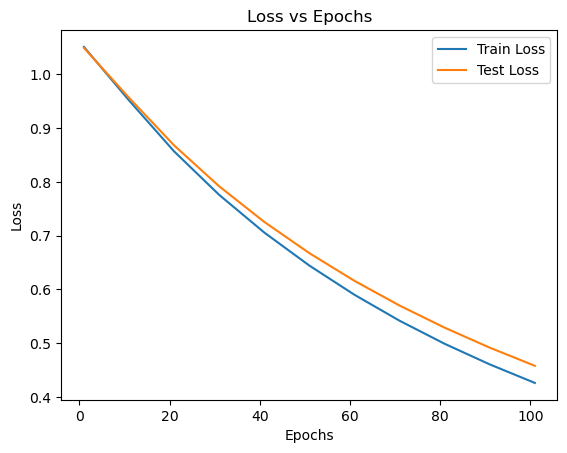

In [82]:
plt.plot(range(1, 10*len(train_losses) + 1, 10), train_losses, label='Train Loss')
plt.plot(range(1, 10*len(train_losses) + 1, 10), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

<h4> - Plot 2: Training and test accuracy vs. epochs</h4>

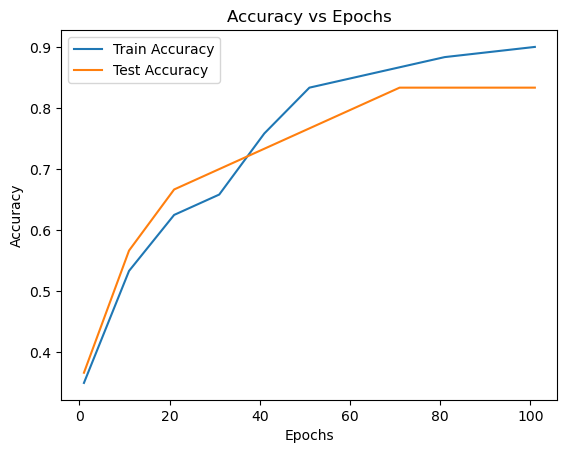

In [83]:
x_values = range(1, 10*len(train_losses) + 1, 10)

plt.plot(x_values, train_accuracies, label='Train Accuracy')
plt.plot(x_values, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

<h4> - Plot 3: Final confusion matrix (visualized as a heatmap with class labels)</h4>

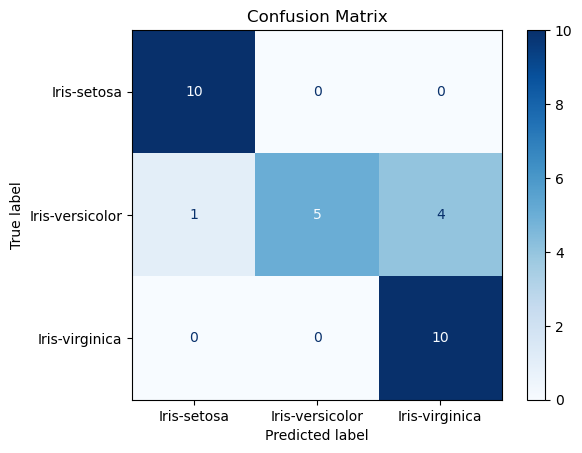

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay

final_preds = torch.argmax(model(X_test_tensor), dim=1)
cm = confusion_matrix(y_test_tensor, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()